# 1. Overview

# 2. Forecasting

## 2.1 Import Libraries

In [1]:
# pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import itertools
import joblib
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Desactivar logs de Prophet
logging.getLogger('cmdstanpy').disabled = True

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global variables

In [3]:
input_data = 'data/weekly_data_combination.csv'
output_model_path = 'models/prophet_asml_combination_with_suppliers.pkl'
output_best_params_path = 'data/best_prophet_params.json'
output_best_variables_path = 'data/best_prophet_variables_with_suppliers.json'
regressors = ['Close_Carl Zeiss Meditec', 'Close_Lam Research Corporation', 
              'Close_Tokyo Electron Limited', 'COVID_Period', 
              'Geopolitical_Tension', 'Trade_Sanctions', 
              'Tech_Regulation', 'New_Product_Launch']
test_weeks = 16

## 2.3 Functions

In [4]:
# Feature engineering for time series
def create_features(df):
    """
    Create time-based features for time series data.
    
    Input:
    - df: DataFrame with a datetime index and a single column for the target variable.

    Output:
    - df: DataFrame with added columns for year, month, week of the year, quarter, and cuatrimestre.

    Logic:
    - Extracts the 'year', 'month', 'week_of_year', 'quarter', and 'cuatrimestre' 
      from the datetime index to create additional time-based features.
    """
    df = df.copy()  # Create a copy of the DataFrame to avoid the warning
    df['year'] = df.index.year            # Extract year from the date
    df['month'] = df.index.month          # Extract month from the date
    df['week_of_year'] = df.index.isocalendar().week  # Extract week of the year from the date
    df['quarter'] = df.index.quarter      # Extract quarter from the date
    df['cuatrimestre'] = ((df.index.month - 1) // 4) + 1  # Calculate cuatrimestre (four-month period)
    return df

## 2.4 Code

Loading the data from notebook 04_data_preparation

In [5]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')


weekly_data_combination.head()

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2013-01-13,56.546032,26.057859,1.512370,7.480000,0,0,0,0,0,0,0
2013-01-20,57.203339,27.226334,1.542561,7.460000,0,0,0,0,0,0,0
2013-01-27,62.106476,27.674398,1.613812,7.406667,0,0,0,0,0,0,0
2013-02-03,66.858612,28.728661,1.679427,7.140000,0,0,0,0,0,0,0
2013-02-10,67.498146,29.343645,1.713643,6.853333,0,0,0,0,0,0,0


### 2.4.1 Train test split

We are going to consider *test_weeks* as the number of weeks we want the test to have

In [6]:
train_data = weekly_data_combination[:-test_weeks]
train_data.head()

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2013-01-13,56.546032,26.057859,1.512370,7.480000,0,0,0,0,0,0,0
2013-01-20,57.203339,27.226334,1.542561,7.460000,0,0,0,0,0,0,0
2013-01-27,62.106476,27.674398,1.613812,7.406667,0,0,0,0,0,0,0
2013-02-03,66.858612,28.728661,1.679427,7.140000,0,0,0,0,0,0,0
2013-02-10,67.498146,29.343645,1.713643,6.853333,0,0,0,0,0,0,0


In [7]:
test_data = weekly_data_combination[-test_weeks:]
test_data.head()

,Close_ASML,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
Date,,,,,,,,,,,
2024-07-28,884.693542,66.550003,90.711090,94.610001,0,1,1,1,1,1,0
2024-08-04,868.534058,68.070000,85.226768,92.120003,0,1,1,1,1,1,0
2024-08-11,841.057861,68.430000,76.805382,86.529999,0,1,1,1,1,1,0
2024-08-18,877.543152,68.449997,84.276657,95.220001,0,1,1,1,1,1,0
2024-08-25,924.035217,69.900002,86.024345,96.559998,0,1,1,1,1,1,0


Let's visualize what would be the result of the train and test dataframes

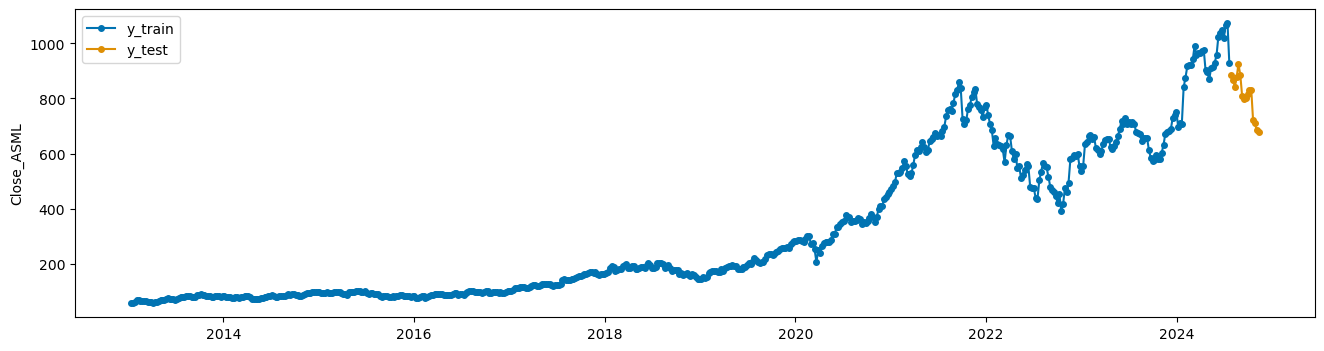

In [8]:
plot_series(train_data['Close_ASML'], test_data['Close_ASML'], labels=["y_train", "y_test"]);

### 2.4.2 SARIMAX

As we saw in notebook 02_forecasting, the series was not stationary, thus we will make the target variable stationary (which is 'Close_ASML') following the same logic that was done in notebook 02_forecasting

Step 1: Log transformation (to stabilize variance)

In [9]:
log_train_data = np.log(train_data['Close_ASML'])

Step 2: Check stationarity using the Augmented Dickey-Fuller test and Differencing if necessary

In [10]:
# Augmented Dickey-Fuller test
result = adfuller(log_train_data, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')

if p_value > 0.05:
    print("The series is not stationary. Applying differencing.")
    # Differencing to achieve stationarity
    diff_log_train_data = log_train_data.diff().dropna()

    # Check stationarity again after differencing
    result_diff = adfuller(diff_log_train_data, autolag='AIC')
    p_value_diff = result_diff[1]
    print(f'ADF Statistic after differencing: {result_diff[0]}')
    print(f'p-value after differencing: {p_value_diff}')

    if p_value_diff > 0.05:
        print("The series is still not stationary.")
    else:
        print("The series is now stationary with differencing.")
    train_data_stationary = diff_log_train_data
else:
    print("The series is stationary with only log.")
    train_data_stationary = log_train_data

ADF Statistic: -0.43518907086606357
p-value: 0.9040556055577966
The series is not stationary. Applying differencing.
ADF Statistic after differencing: -21.87594324404594
p-value after differencing: 0.0
The series is now stationary with differencing.


Plot the transformed data to visualize

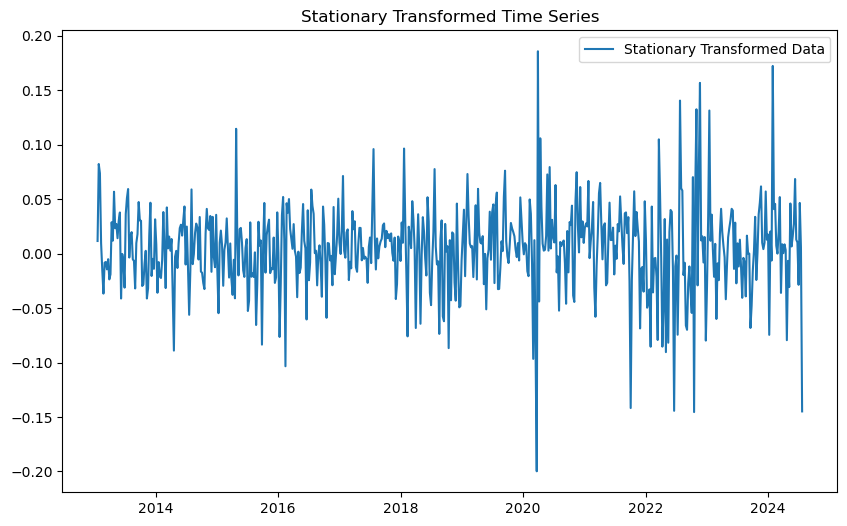

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_data_stationary, label='Stationary Transformed Data')
plt.title('Stationary Transformed Time Series')
plt.legend()
plt.show()

Once we have the stationary series, we initialize the SARIMAX model with the corresponding regressor variables

In [12]:
# Creating the exogenous variables
exog = train_data.drop(['Close_ASML'], axis=1)
# Deleting the first row of exog due to the differentiation
exog = exog[1:]

# Initializing the SARIMAX model
sarima_model = SARIMAX(
    train_data_stationary,     # Training data that is stationary
    exog=exog,                 # Exogenous variables
    order=(1, 1, 1),           # ARIMA order (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # Seasonal order (P, D, Q, s), here s=52 for weekly data
    enforce_stationarity=False,  # Allow the model to be non-stationary
    enforce_invertibility=False  # Allow the model to be non-invertible
)

In [13]:
# Fit the model to the training data
fitted_sarima = sarima_model.fit(disp=False)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Generate predictions the future_exog variable
future_exog = test_data.drop('Close_ASML', axis=1)

# Assuming `future_exog` contains the future values of the exogenous variables for the forecast period
y_pred_sarima = fitted_sarima.forecast(steps=len(test_data), exog=future_exog)

Now we have to revert the transformations

In [15]:
# Step 1: Revert the differencing
# 'last_original_value' is the last value before differencing was applied
last_original_value = log_train_data.iloc[-1]

# Add back the last original value to get the cumulative sum and revert differencing
y_pred_sarima_diff_reverted = np.r_[last_original_value, y_pred_sarima].cumsum()

# Remove the first value to match the length of test_data
y_pred_sarima_diff_reverted = y_pred_sarima_diff_reverted[1:]

# Step 2: Revert the logarithmic transformation
y_pred_sarima_reverted = np.exp(y_pred_sarima_diff_reverted)

# Convert the reverted predictions to a pandas Series
y_pred_sarima_reverted = pd.Series(y_pred_sarima_reverted, index=test_data.index)

Let's plot the data and predictions

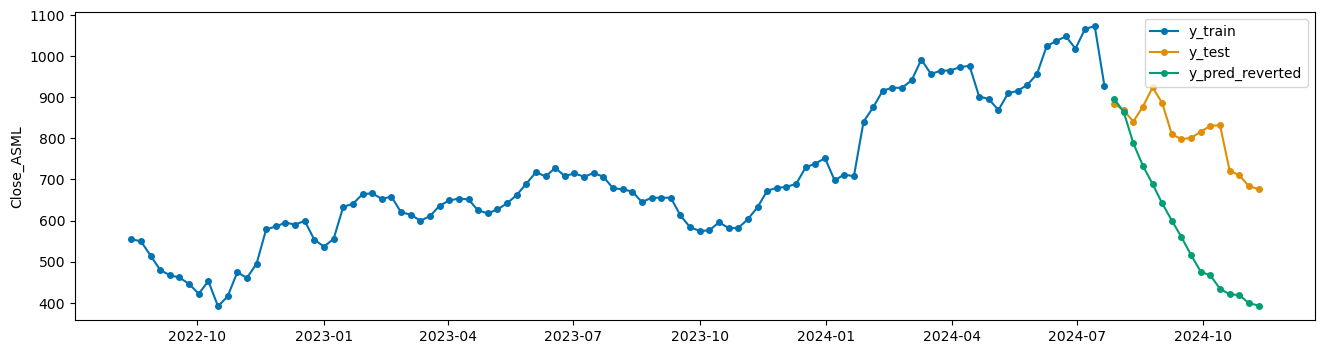

In [16]:
# Plot the training, test data, and predictions
plot_series(train_data['Close_ASML'][500:], test_data['Close_ASML'], y_pred_sarima_reverted, labels=["y_train", "y_test", "y_pred_reverted"]);

In [17]:
# Calculate MAPE for SARIMA model
mape_sarima = mean_absolute_percentage_error(test_data['Close_ASML'], y_pred_sarima_reverted) * 100
mape_sarima

29.291977664322765

In [18]:
# Calculate RMSE for SARIMA model
rmse_sarima = root_mean_squared_error(test_data['Close_ASML'], y_pred_sarima_reverted)
rmse_sarima

258.0218976537901

The results are not good if they're compared with those of notebook 02_forecasting. So, we are disregarding the SARIMAX model for now.

### 2.4.3 Prophet

Initialize the Prophet model

In [19]:
prophet_model = Prophet()

Fit the model to the data

First we need to modify the column names as is required by prophet

In [20]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
train_data_prophet.head()

,ds,y,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
0,2013-01-13,56.546032,26.057859,1.512370,7.480000,0,0,0,0,0,0,0
1,2013-01-20,57.203339,27.226334,1.542561,7.460000,0,0,0,0,0,0,0
2,2013-01-27,62.106476,27.674398,1.613812,7.406667,0,0,0,0,0,0,0
3,2013-02-03,66.858612,28.728661,1.679427,7.140000,0,0,0,0,0,0,0
4,2013-02-10,67.498146,29.343645,1.713643,6.853333,0,0,0,0,0,0,0


In [21]:
test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
test_data_prophet.head()

,ds,y,Close_Carl Zeiss Meditec,Close_Lam Research Corporation,Close_Tokyo Electron Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict,Economic_Stimulus
0,2024-07-28,884.693542,66.550003,90.711090,94.610001,0,1,1,1,1,1,0
1,2024-08-04,868.534058,68.070000,85.226768,92.120003,0,1,1,1,1,1,0
2,2024-08-11,841.057861,68.430000,76.805382,86.529999,0,1,1,1,1,1,0
3,2024-08-18,877.543152,68.449997,84.276657,95.220001,0,1,1,1,1,1,0
4,2024-08-25,924.035217,69.900002,86.024345,96.559998,0,1,1,1,1,1,0


Add each regressor to the Prophet model

In [22]:
for regressor in regressors:
    prophet_model.add_regressor(regressor)

Fit the model

In [23]:
prophet_model.fit(train_data_prophet)

In [24]:
# Generate predictions
forecast = prophet_model.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,COVID_Period,COVID_Period_lower,COVID_Period_upper,Close_Carl Zeiss Meditec,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-28,464.213524,807.169591,867.230013,464.213524,464.213524,0.0,0.0,0.0,-25.286498,...,372.988425,372.988425,372.988425,-0.097372,-0.097372,-0.097372,0.0,0.0,0.0,837.104577
1,2024-08-04,465.251711,776.357935,835.897341,465.251711,465.251711,0.0,0.0,0.0,-22.484685,...,343.147311,343.147311,343.147311,-2.901018,-2.901018,-2.901018,0.0,0.0,0.0,805.498004
2,2024-08-11,466.289898,722.966739,784.015026,466.289898,466.289898,0.0,0.0,0.0,-21.821095,...,291.565533,291.565533,291.565533,-3.328184,-3.328184,-3.328184,0.0,0.0,0.0,754.527248
3,2024-08-18,467.328085,775.963451,836.321169,467.328085,467.328085,0.0,0.0,0.0,-21.784235,...,342.432452,342.432452,342.432452,-1.985261,-1.985261,-1.985261,0.0,0.0,0.0,807.775276
4,2024-08-25,468.366273,794.040787,854.428186,468.366273,468.366273,0.0,0.0,0.0,-19.111438,...,356.163711,356.163711,356.163711,-0.089465,-0.089465,-0.089465,0.0,0.0,0.0,824.440519


Plot forecast components (trend, weekly, yearly components)

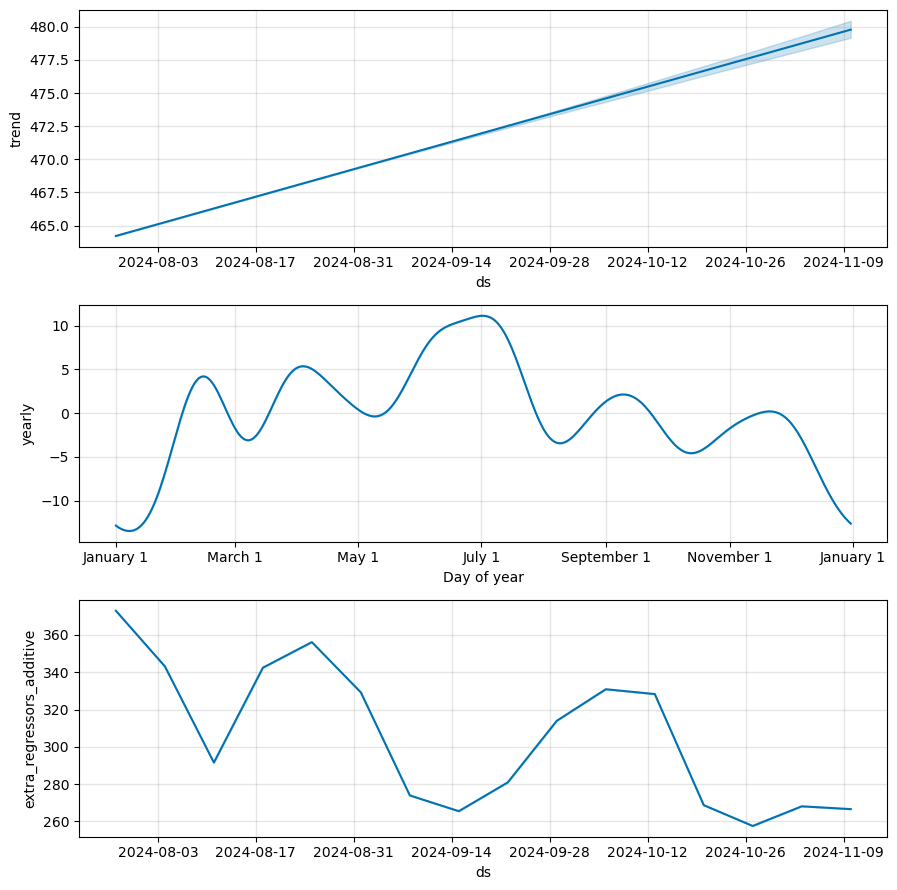

In [25]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

The Prophet model's forecast shows a steady upward trend, indicating growth over time. There is clear yearly seasonality, with peaks around July and dips towards the year's end, suggesting cyclical behavior. An additional regressor also impacts the forecast, introducing periodic fluctuations that align with external factors. Together, these components suggest the forecast is influenced by an overall upward trend, annual cycles, and external variables.

In [26]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

forecast

,Close
ds,
2024-07-28,837.104577
2024-08-04,805.498004
2024-08-11,754.527248
2024-08-18,807.775276
2024-08-25,824.440519
2024-09-01,800.047727
2024-09-08,746.478615
2024-09-15,738.676257
2024-09-22,753.644499


In [27]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Ensure ds is the index of test_data_prophet 
test_data_prophet = test_data_prophet.set_index('ds')

Plot the forecast results

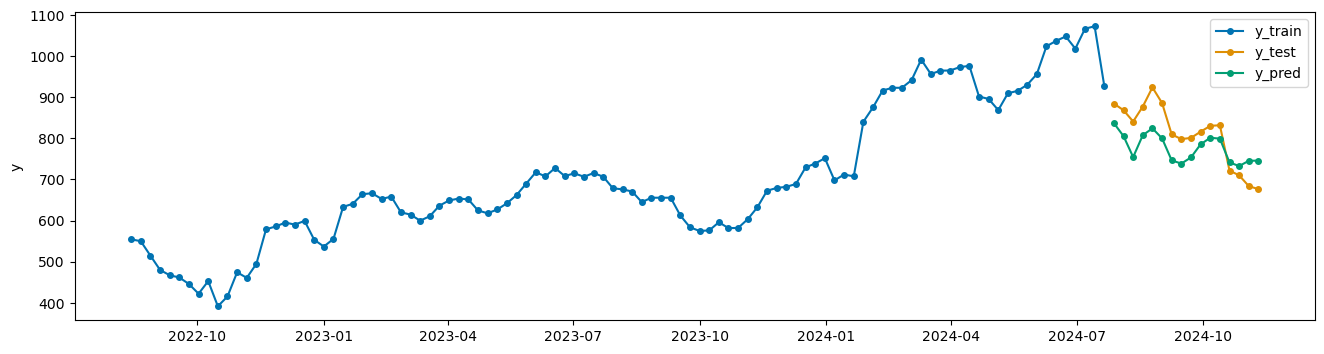

In [28]:
plot_series(train_data_prophet[['y']][500:], test_data_prophet[['y']], forecast, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [29]:
mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast) * 100
mape_prophet

6.809101085534011

In [30]:
rmse_prophet = root_mean_squared_error(test_data_prophet['y'], forecast)
rmse_prophet

60.250589931672316

The results are very positive. So, it's interesting to consider the extra information that the regressors provide. We will still try other models to see their results. All things considered, results seem to be good for now.

### 2.4.6 XGboost

We will try again XGBoost as we did in notebook 02_forecasting and we will do so using the temporal variables using the create_features function.

In [31]:
train_data_xgb_rf = create_features(train_data)
test_data_xgb_rf = create_features(test_data)

In [32]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_xgb = train_data_xgb_rf.drop('Close_ASML', axis=1)
y_train_xgb = train_data_xgb_rf['Close_ASML']
X_test_xgb = test_data_xgb_rf.drop('Close_ASML', axis=1)
y_test_xgb = test_data_xgb_rf['Close_ASML']

In [33]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [34]:
# Train the model
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [35]:
# Generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb, index=test_data.index, columns=['Close_ASML'])

In [36]:
# Evaluate the model's performance
rmse_xgb = root_mean_squared_error(y_test_xgb, y_pred_xgb)
rmse_xgb

87.27021888386835

In [37]:
mape_xgb = mean_absolute_percentage_error(y_test_xgb, y_pred_xgb)*100
mape_xgb

9.264653468625559

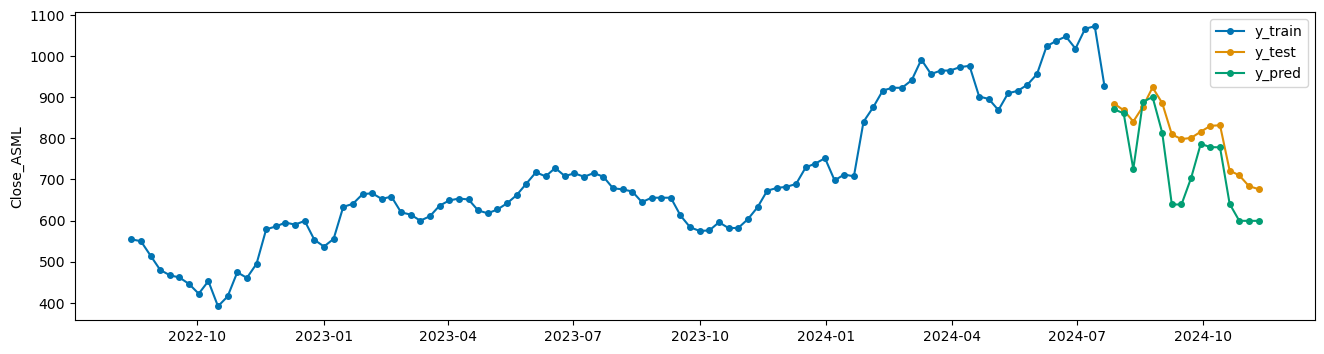

In [38]:
# Plot actual vs. predicted values
plot_series(y_train_xgb[500:], y_test_xgb, y_pred_xgb, labels=["y_train", "y_test", "y_pred"]);

Results if compared with the previous prophet models are not so good in a numerical and visual sense and so, we will still choose the prophet as our main model.

### 2.4.7 Random Forest

We will proceed with the Random Forest model using the same logic that we used for XGBoost.

In [39]:
# Prepare X and y for the model
# Since we're not adding any features, we simply use the index as an integer sequence
X_train_rf = train_data_xgb_rf.drop('Close_ASML', axis=1)
y_train_rf = train_data_xgb_rf['Close_ASML']
X_test_rf = test_data_xgb_rf.drop('Close_ASML', axis=1)
y_test_rf = test_data_xgb_rf['Close_ASML']

In [40]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,       # Number of trees
    max_depth=5,            # Maximum depth of trees
    random_state=42         # For reproducibility
)

In [41]:
# Train the model
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, random_state=42)

In [42]:
# Generate predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Convert predictions to a DataFrame with the same index as the test data
y_pred_rf = pd.DataFrame(y_pred_rf, index=test_data.index, columns=['Close'])

In [43]:
# Evaluate the model's performance
rmse_rf = root_mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf

88.16650626524336

In [44]:
mape_rf = mean_absolute_percentage_error(y_test_rf, y_pred_rf)*100
mape_rf

8.556415250217391

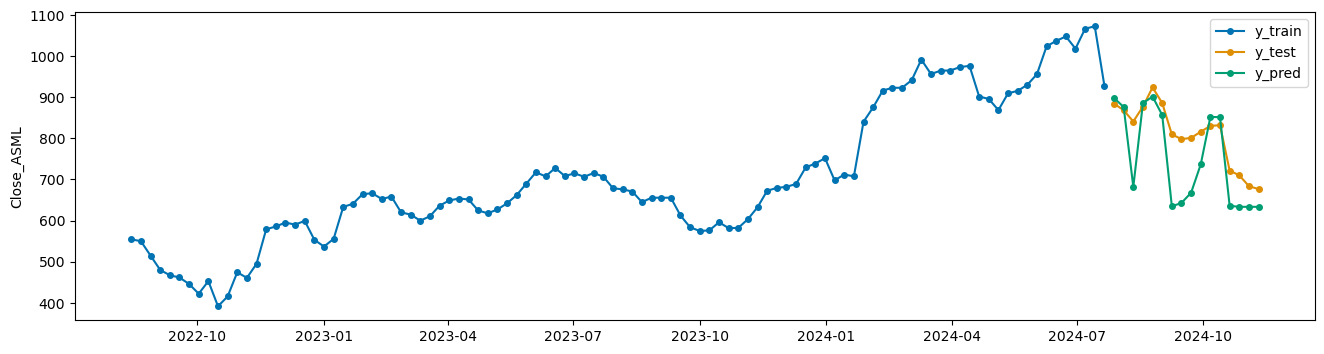

In [45]:
# Plot actual vs. predicted values
plot_series(y_train_rf[500:], y_test_rf, y_pred_rf, labels=["y_train", "y_test", "y_pred"]);

The results are far from convincing. So, we decide to keep with the prophet model. Nevertheless, we will create a table that compares the MAPE and RMSE results of all the models in the following code cells.

### 2.4.8 RMSE and MAPE comparison

In [46]:
# Create a dictionary to store RMSE and MAPE for each model
metrics = {
    "Model": ["SARIMAX", "Prophet", "XGBoost", "Random Forest"],
    "RMSE": [
        rmse_sarima,
        rmse_prophet,
        rmse_xgb,
        rmse_rf
    ],
    "MAPE": [
        mape_sarima,
        mape_prophet,
        mape_xgb,
        mape_rf
    ]
}

In [47]:
# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,RMSE,MAPE
0,SARIMAX,258.021898,29.291978
1,Prophet,60.250590,6.809101
2,XGBoost,87.270219,9.264653
3,Random Forest,88.166506,8.556415


Our best model is Prophet as it has the lowest RMSE and MAPE. We shall now proceed to do a fine-tunning of the prophet model. We will be disregarding the other models because they are significantly worse in performance.

### 2.4.9 Fine-tunning

Let's investigate the following models after doing a fine-tunning: Prophet

In [48]:
# Define the refined range of parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],    # Best result was with 'additive' mode
    'changepoint_prior_scale': [1.0, 1.1, 1.2],            # Narrowed around the best value 0.07
    'seasonality_prior_scale': [1.8, 1.9, 2.0],            # Focused around the best value 1.5
    'yearly_seasonality': [True, False],                   # Best result was with yearly seasonality set to False
    'weekly_seasonality': [True, False],                   # Best result was with weekly seasonality set to True
    'daily_seasonality': [True, False]                     # Best result was with daily seasonality set to False
}

# Create combinations of parameters
grid = ParameterGrid(param_grid)

best_mape = float('inf')
best_params = None
best_model = None

for params in grid:
    model = Prophet(
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        yearly_seasonality=params['yearly_seasonality'],
        weekly_seasonality=params['weekly_seasonality'],
        daily_seasonality=params['daily_seasonality']
    )
    
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
    test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})
    
    for regressor in regressors:
        model.add_regressor(regressor)
    
    model.fit(train_data_prophet)
    
    # Generate predictions
    forecast = model.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])
    forecast_filtered = forecast[['yhat']].rename(columns={'yhat': 'Close'})
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test_data_prophet['y'], forecast_filtered.loc[test_data_prophet.index])
    
    # Calculate RMSE
    rmse = root_mean_squared_error(test_data_prophet['y'], forecast_filtered.loc[test_data_prophet.index])
    
    if mape < best_mape:
        best_mape = mape
        best_rmse = rmse
        best_params = params
        best_model = model

print(f"Best parameters: {best_params} with MAPE: {best_mape*100:.2f}% and RMSE: {best_rmse:.2f}")

Best parameters: {'changepoint_prior_scale': 1.1, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.9, 'weekly_seasonality': True, 'yearly_seasonality': True} with MAPE: 6.50% and RMSE: 58.56


Let's now do again the prophet model with the best parameters

Initialize the Prophet model

In [49]:
prophet_model_best = Prophet(
                changepoint_prior_scale=best_params['changepoint_prior_scale'],
                daily_seasonality=best_params['daily_seasonality'],
                seasonality_mode=best_params['seasonality_mode'],
                seasonality_prior_scale=best_params['seasonality_prior_scale'],
                weekly_seasonality=best_params['weekly_seasonality'],
                yearly_seasonality=best_params['yearly_seasonality']
            )

Fit the model to the data

First we need to modify the column names as is required by prophet

In [50]:
# For train
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})

# For test
test_data_prophet = test_data.reset_index(names="ds").rename(columns={'Close_ASML':'y'})

Adding the regressors

In [51]:
for regressor in regressors:
    prophet_model_best.add_regressor(regressor)

Doing the fit of the model

In [52]:
prophet_model_best.fit(train_data_prophet)

In [53]:
# Generate predictions
forecast_best = prophet_model_best.predict(test_data_prophet[[column for column in test_data_prophet if column != 'y']])

Plot forecast components (trend, weekly, yearly components)

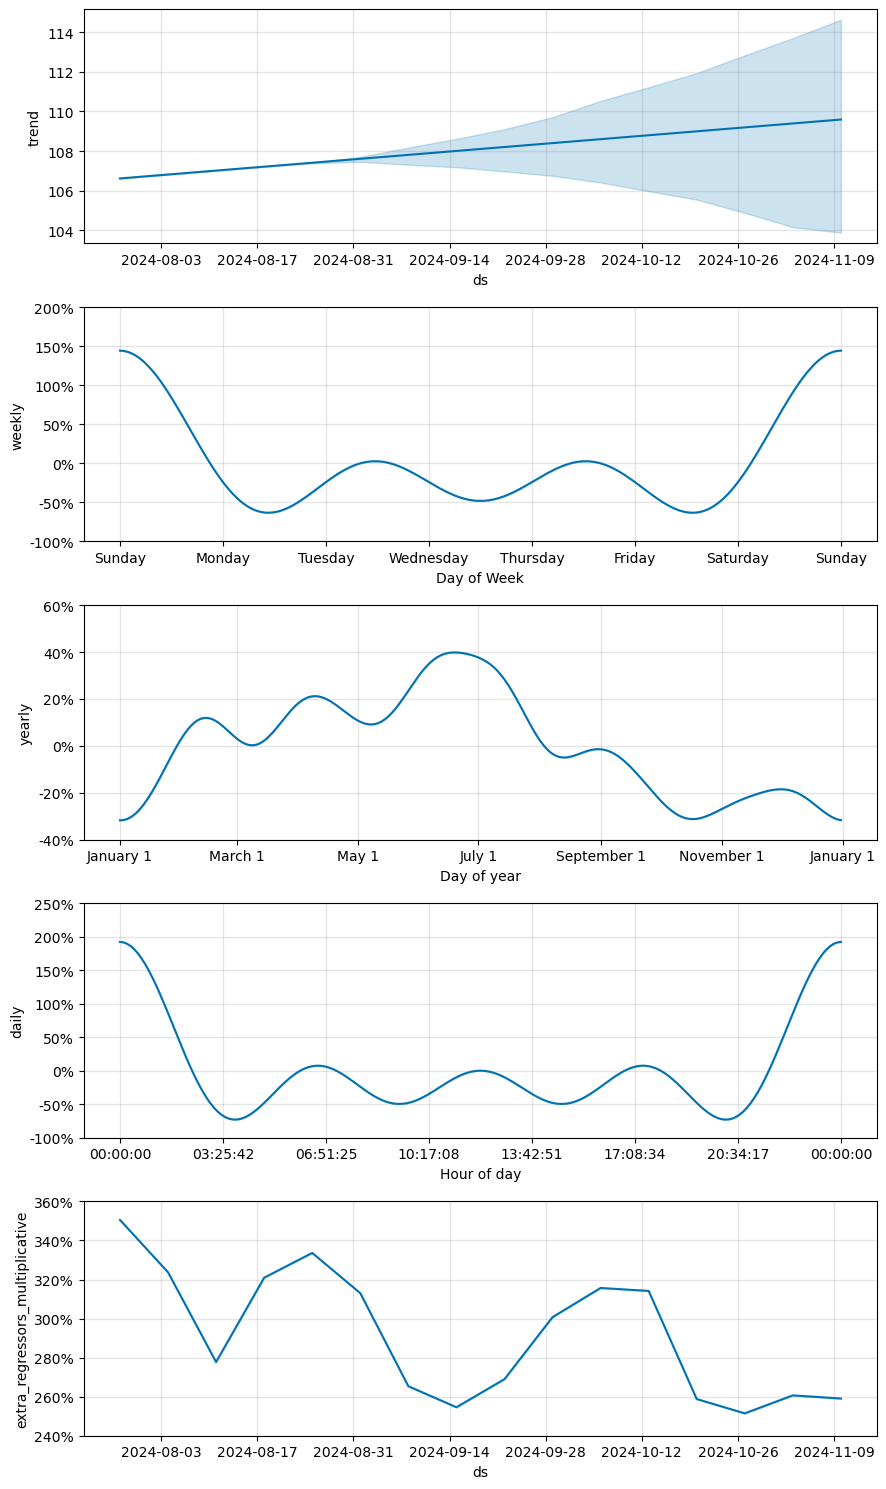

In [54]:
fig2 = prophet_model_best.plot_components(forecast_best)
plt.show()

In [55]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_best = forecast_best[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

forecast_best

,Close
ds,
2024-07-28,847.054977
2024-08-04,810.869897
2024-08-11,759.228170
2024-08-18,807.594715
2024-08-25,824.956230
2024-09-01,804.951881
2024-09-08,752.673384
2024-09-15,737.202451
2024-09-22,747.131381


In [56]:
# Ensure ds is the index of train_data_prophet 
train_data_prophet = train_data_prophet.set_index('ds')

# Ensure ds is the index of test_data_prophet 
test_data_prophet = test_data_prophet.set_index('ds')

Plot the forecast results

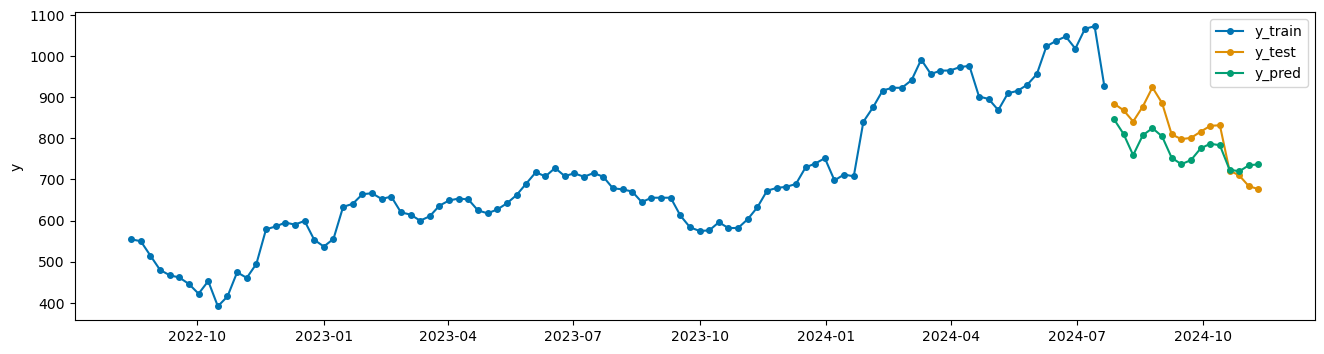

In [57]:
plot_series(train_data_prophet['y'][500:], test_data_prophet['y'], forecast_best, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [58]:
mape_prophet_best = mean_absolute_percentage_error(test_data_prophet['y'], forecast_best) * 100

mape_prophet_best

6.501896167175672

In [59]:
rmse_prophet_best = root_mean_squared_error(test_data_prophet['y'], forecast_best)
rmse_prophet_best

58.555629267830646

As can be seen, the prophet RMSE and MAPE results improve with the fine-tunning

#### 2.4.9.4 Results

The final fine-tune prophet model improved the MAPE and the RMSE results with respect to the non-fine tunned prophet model

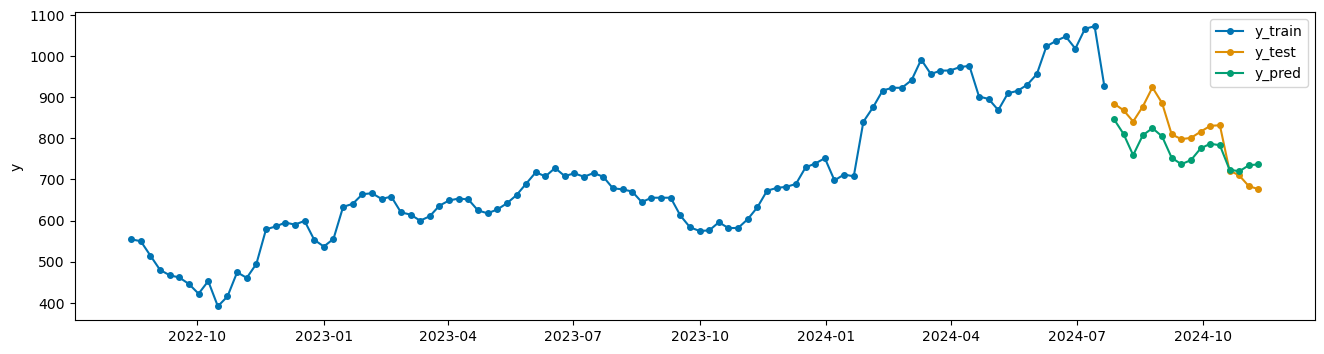

In [60]:
plot_series(train_data_prophet['y'][500:], test_data_prophet['y'], forecast_best, labels=["y_train", "y_test", "y_pred"]);

#### 2.4.9.5 Save the best model and best rmse and MAPE

Saving the rmse_prophet_best and rmse_prophet_best variables

In [61]:
# Variable definition
best_prophet_variables_with_suppliers = {"rmse_prophet_best_with_suppliers": rmse_prophet_best, 
                                         "mape_prophet_best_with_suppliers": mape_prophet_best}

# Save the variable to a JSON file
with open(output_best_variables_path, 'w') as file:
    json.dump(best_prophet_variables_with_suppliers, file)

In [62]:
# Saving the best model
joblib.dump(prophet_model_best, output_model_path)

# Save the best parameters to a JSON file
with open(output_best_params_path, 'w') as file:
    json.dump(best_params, file, indent=4)